In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial 

%matplotlib inline

In [2]:
# Here are three interesting sets of parameters to explore. 
p_common = { "b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1,}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [3]:
def A(u, a, b):
    """Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate."""
    return a + b * u

def F1_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return (d*K)/(A(u1, a, b)*u1*N1 + A(u2, a, b)*u2*N2 + d)

def F2_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 2."""
    return (d*K)/(A(u1, a, b)*(1-u1)*N1 + A(u2, a, b)*(1-u2)*N2 + d)
                 
def beta(u, F1, F2, a1, b1, a2, b2):
    """Birth rate of a predator with trait u"""
    return (  F1 * A(u, a1, b1) * u 
            + F2 * A(u, a2, b2) * (1-u)) 
            
def growth_rate(N1, N2, u1, u2, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Per capita growth rate of predator species N1 when the prey is at QSS"""
    F1 = F1_QSS(d1, K1, a1, b1, u1, N1, u2, N2)
    F2 = F2_QSS(d2, K2, a2, b2, u1, N1, u2, N2)
    return beta(u1, F1, F2, a1, b1, a2, b2) - mu

def n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    # Rough estimate used to initialise the optimisation algorithm.
    estimate = (d1*K1+d2*K2)/mu
    
    # We fix the value of the other parameters before solving for N1.
    resident_growth_rate = partial(growth_rate,
                                   u1 = r,
                                   N2=0, u2=0,
                                   a1=a1, a2=a2, 
                                   b1=b1, b2=b2, 
                                   d1=d1, d2=d2,
                                   K1=K1, K2=K2, 
                                   mu=mu)
    return scipy.optimize.fsolve(resident_growth_rate,x0=estimate)
    
def invasion_fitness(m, r, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Invasion fitness of a rare mutant type with trait m in a resident population
    with trait r"""
    
    # Conpute the ecological equilibrium of the resident.
    Nstar = n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu)
    
    # Invasion fitness is the growth rate of a rare mutant (N=0, u=m)
    # in a resident population at equilibrium (N=Nstar, u=r)
    return growth_rate(N1=0, N2=Nstar, u1=m, u2=r, 
                       a1=a1, a2=a2, b1=b1, b2=b2, K1=K1, 
                       K2=K2, d1=d1, d2=d2, mu=mu)

In [5]:
def compute_pip(steps, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Return 3 matrices of size step X step:
    R: Resident population trait (constant on each column, go from 0 to 1 in the first and last column).
    M: Mutant population trait (constant on each line, go from 0 to 1 between the first and last line)
    PIP: Corresponding invasion fitness."""
    
    # Fill the R, M matrices with evenly spaced values in [0,1]. 
    R,M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))
    
    # Python tip: An efficient way to compute a multiple variable function over a domain
    # is to convert it to a "broadcastable function" that can be applied to multiple values at 
    # once. Here I do it with np.frompyfunc.
    # https://docs.scipy.org/doc/numpy/reference/ufuncs.html?highlight=ufunc for more info.
    #
    # An alternative is to loop over all values in my input matrices 
    # M and R and fill the PIP matrix one element at a time.
    s = partial(invasion_fitness, a1=a1, a2=a2,
                                  b1=b1, b2=b2,
                                  d1=d1, d2=d2,
                                  K1=K1, K2=K2,
                                  mu=mu)
    s = np.frompyfunc(s, 2, 1)
    PIP = s(M, R)
    return R, M, PIP

def display_pip(PIP, R, M, ax=None):
    """Use matplotlib to display the PIP"""
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    m = ax.contourf(R, M, PIP, 
                levels=[PIP.min(),0,PIP.max()],
                colors=['w','k'])
    ax.set(title='Pairwise invasibility plot', 
       ylabel='Mutant trait m',
       xlabel='resident trait r')

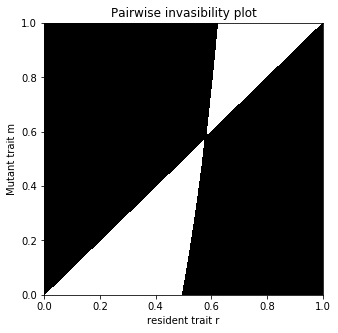

In [6]:
R, M, PIP = compute_pip(100,**p_strong)
display_pip(PIP, R, M)